# XGBoost

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_contour, plot_slice
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

from model_utils import calc_gini_coef, plot_pr_curve, plot_roc_curve

C:\Users\dan\PycharmProjects\ds\ff_internship\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
from model_utils import split_dataset_v2

# CLIENT_PATH = '../data/initial/CLIENTS.csv'
# FEATURES_PATH = '../data/features/features_no_row_delete_inner_join.csv'
# X_train, X_valid, X_test, y_train, y_valid, y_test = split_dataset(CLIENT_PATH, FEATURES_PATH, valid_size=0.2)

# FEATURES_PATH = '../data/features/features_auto_v6.csv'
# FEATURES_PATH = '../data/features_selected/features_v6_filtered_v4.csv'
# FEATURES_PATH = '../data/features_selected/features_v6_embedded_v4.csv'
# FEATURES_PATH = '../data/features_selected/features_v6_wrappered_v6.csv'
# FEATURES_PATH = '../data/features_selected/features_v6_rfe_lgb_v4.csv'

FEATURES_PATH = '../prod_test/features/features_v1_rfe_step2_lgb_v1.csv'

X_train, X_valid, X_test, y_train, y_valid, y_test = split_dataset_v2(FEATURES_PATH, valid_size=0.2)

## Hyperparameters tuning

### Random search

In [76]:
param_dist = {
    'n_estimators': [400, 600, 800, 1000],
    'learning_rate': np.linspace(0.01, 0.1, 10),
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5, 8, 12],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8],
    'gamma': [0, 0.05, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [1, 2, 3, 5]
}

# param_dist = {
#     'max_depth': [2, 3, 4],
#     'min_child_weight': [10, 20, 40, 80],
#     'gamma': [0.2, 0.4, 0.6],
#     'subsample': [0.5, 0.6, 0.7],
#     'colsample_bytree': [0.5, 0.6, 0.7],
#     'reg_alpha': [1, 2, 5],
#     'reg_lambda': [5, 10, 20],
#     'n_estimators': [200, 400, 600],
#     'learning_rate': [0.03, 0.05]
# }

In [77]:
model_base = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=3,
    eval_metric='logloss',
    n_jobs=6,
    random_state=42,
    early_stopping_rounds=50,
)

In [ ]:
random_search = RandomizedSearchCV(
    estimator=model_base,
    param_distributions=param_dist,
    n_iter=40,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=6,
)

random_search.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=True,
)

In [79]:
random_search.best_params_

{'subsample': 0.6,
 'reg_lambda': 5,
 'reg_alpha': 1.0,
 'n_estimators': 800,
 'min_child_weight': 1,
 'max_depth': 5,
 'learning_rate': np.float64(0.020000000000000004),
 'gamma': 0.1,
 'colsample_bytree': 0.5}

## Bayesian Optimization

In [182]:
ALPHA = 0.25  # used for penalizing gap between train and validation score

def objective(trial):

    # params = {
    #     'objective': 'binary:logistic',
    #     'eval_metric': 'auc',
    #     'booster': 'gbtree',
    #     'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.08),
    #     'n_estimators': trial.suggest_int('n_estimators', 200, 1200),
    #     'max_depth': trial.suggest_int('max_depth', 1, 5),
    #     'min_child_weight': trial.suggest_int('min_child_weight', 10, 300),
    #     'gamma': trial.suggest_float('gamma', 0.1, 1.0),
    #     'subsample': trial.suggest_float('subsample', 0.5, 0.7),
    #     'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.7),
    #     'reg_alpha': trial.suggest_float('reg_alpha', 0.5, 3.0),
    #     'reg_lambda': trial.suggest_float('reg_lambda', 3.0, 30.0),
    #     'scale_pos_weight': 3,
    #     'n_jobs': 6,
    #     'random_state': 42,
    #     'early_stopping_rounds': 50,
    # }

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'learning_rate': trial.suggest_float('learning_rate', 0.015, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 800, 1400),
        'max_depth': trial.suggest_int('max_depth', 2, 3),
        'min_child_weight': trial.suggest_int('min_child_weight', 10, 200),
        'gamma': trial.suggest_float('gamma', 0.25, 0.9),
        'subsample': trial.suggest_float('subsample', 0.5, 0.7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.45, 0.65),
        'reg_alpha': 2.0,
        'reg_lambda': 17.0,
        'scale_pos_weight': 3,
        'n_jobs': 6,
        'random_state': 42,
        # 'early_stopping_rounds': 50,
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            verbose=False,
        )

        y_tr_pred_proba = model.predict_proba(X_tr)[:, 1]
        y_va_pred_proba = model.predict_proba(X_va)[:, 1]

        tr_gini = calc_gini_coef(y_tr, y_tr_pred_proba)
        va_gini = calc_gini_coef(y_va, y_va_pred_proba)

        score = va_gini - ALPHA * (tr_gini - va_gini)
        scores.append(score)

    return np.mean(scores)


In [183]:
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective, n_trials=150)

[I 2026-01-23 13:26:11,771] A new study created in memory with name: no-name-85e78551-f746-4e15-ab4f-9760bb5b1705
[I 2026-01-23 13:26:19,027] Trial 0 finished with value: 0.6021486879952849 and parameters: {'learning_rate': 0.028108904159657687, 'n_estimators': 1371, 'max_depth': 3, 'min_child_weight': 124, 'gamma': 0.35141211628758373, 'subsample': 0.5311989040672406, 'colsample_bytree': 0.4616167224336399}. Best is trial 0 with value: 0.6021486879952849.
[I 2026-01-23 13:26:24,216] Trial 1 finished with value: 0.5960663154676493 and parameters: {'learning_rate': 0.04531616510212273, 'n_estimators': 1161, 'max_depth': 3, 'min_child_weight': 13, 'gamma': 0.8804414039052963, 'subsample': 0.6664885281600843, 'colsample_bytree': 0.49246782213565526}. Best is trial 0 with value: 0.6021486879952849.
[I 2026-01-23 13:26:30,801] Trial 2 finished with value: 0.59788013655525 and parameters: {'learning_rate': 0.02136387385224852, 'n_estimators': 910, 'max_depth': 2, 'min_child_weight': 110, 'ga

KeyboardInterrupt: 

In [184]:
print('Best score:', study.best_value)
print('Best params:', study.best_params)

Best score: 0.6067960275870627
Best params: {'learning_rate': 0.04225327796766968, 'n_estimators': 1035, 'max_depth': 2, 'min_child_weight': 76, 'gamma': 0.5228328198194203, 'subsample': 0.6392798256389177, 'colsample_bytree': 0.6382315524552269}


In [185]:
plot_optimization_history(study)

In [186]:
plot_parallel_coordinate(study)

In [187]:
plot_contour(study, params=['n_estimators', 'learning_rate'])

In [188]:
plot_slice(study)

In [189]:
plot_param_importances(study)

## Model training and evaluation

In [80]:
# Random search
model = random_search.best_estimator_

In [190]:
# Bayesian optimization
model = xgb.XGBClassifier(
    **study.best_params,
    objective='binary:logistic',
    eval_metric='auc',
    booster='gbtree',
    reg_alpha=2.0,
    reg_lambda=17.0,
    scale_pos_weight=3,
    n_jobs=6,
    random_state=42,
    # early_stopping_rounds=50,
)

In [5]:
# Bayesian optimization hardcoded
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    booster='gbtree',
    n_estimators=1035,
    learning_rate=0.04225,
    max_depth=2,
    min_child_weight=76,
    gamma=0.52283,
    subsample=0.63927,
    colsample_bytree=0.63823,
    reg_alpha=2.0,
    reg_lambda=17.0,
    scale_pos_weight=3,
    n_jobs=6,
    random_state=42,
    # early_stopping_rounds=50,
)

In [6]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=100,
)

[0]	validation_0-auc:0.68898	validation_1-auc:0.68028
[100]	validation_0-auc:0.78673	validation_1-auc:0.78035
[200]	validation_0-auc:0.80555	validation_1-auc:0.79598
[300]	validation_0-auc:0.81586	validation_1-auc:0.80241
[400]	validation_0-auc:0.82274	validation_1-auc:0.80546
[500]	validation_0-auc:0.82793	validation_1-auc:0.80727
[600]	validation_0-auc:0.83197	validation_1-auc:0.80838
[700]	validation_0-auc:0.83544	validation_1-auc:0.80950
[800]	validation_0-auc:0.83851	validation_1-auc:0.80991
[900]	validation_0-auc:0.84110	validation_1-auc:0.81011
[1000]	validation_0-auc:0.84344	validation_1-auc:0.81015
[1034]	validation_0-auc:0.84423	validation_1-auc:0.81023


,objective,'binary:logistic'
,base_score,None
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.63823
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [7]:
# y_true = y_train
# y_pred_proba = model.predict_proba(X_train)[:, 1]
# y_true = y_valid
# y_pred_proba = model.predict_proba(X_valid)[:, 1]
y_true = y_test
y_pred_proba = model.predict_proba(X_test)[:, 1]

Gini Coefficient:  0.6198714506756304


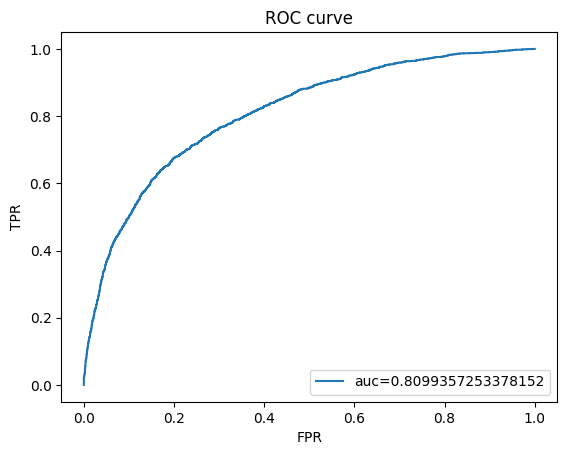

In [8]:
gini_coef = calc_gini_coef(y_true, y_pred_proba)
print('Gini Coefficient: ', gini_coef)

plot_roc_curve(y_true, y_pred_proba)

In [198]:
y_pred = (y_pred_proba >= 0.5).astype(int)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81      5538
           1       0.46      0.72      0.57      1705

    accuracy                           0.74      7243
   macro avg       0.68      0.73      0.69      7243
weighted avg       0.79      0.74      0.75      7243



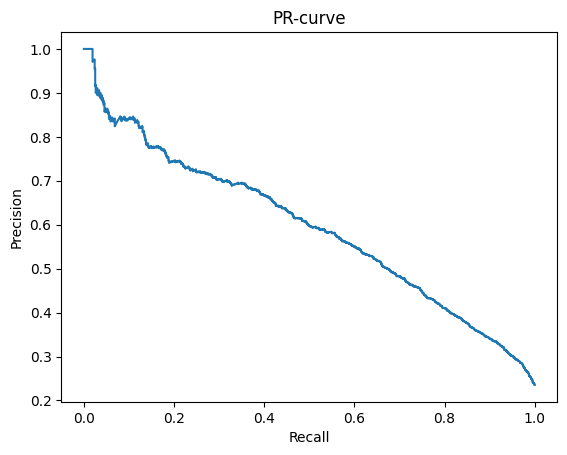

In [199]:
plot_pr_curve(y_true, y_pred_proba)

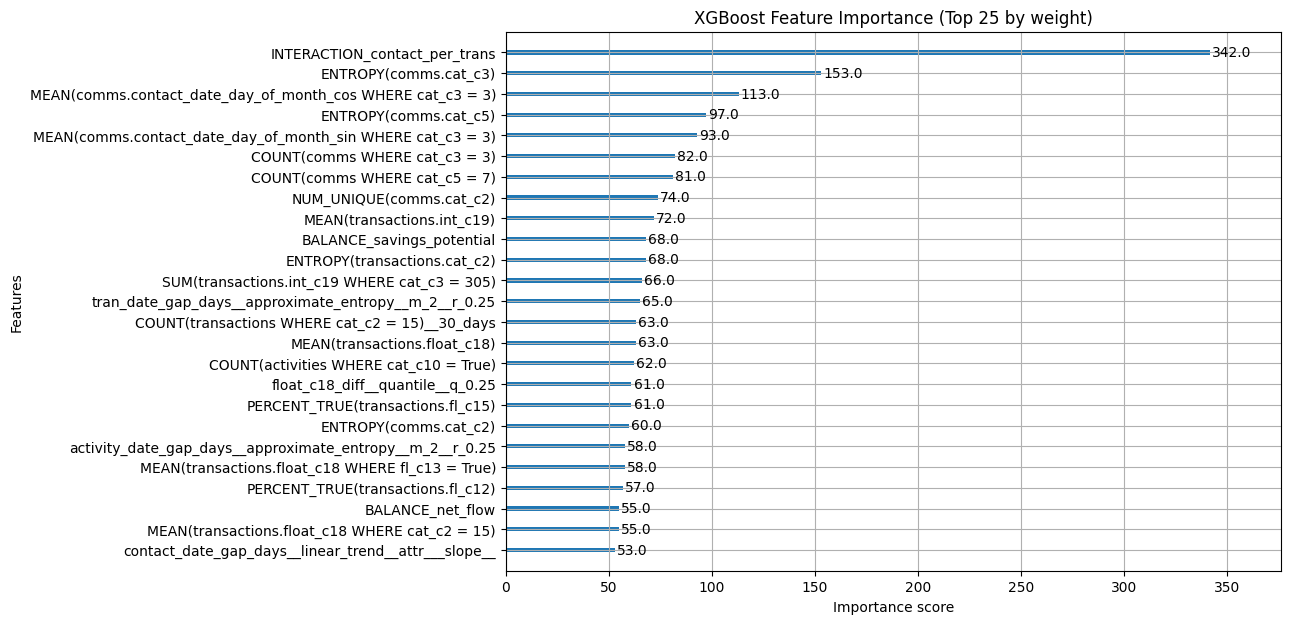

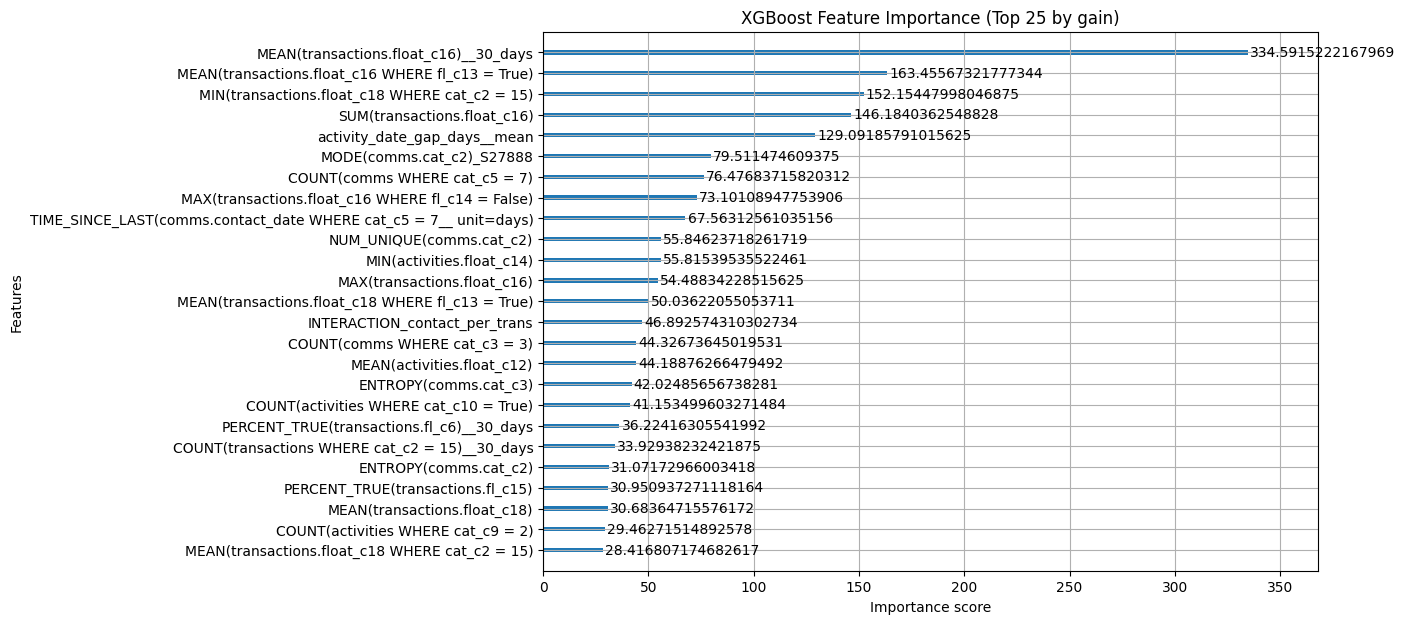

In [200]:
# Feature importance
for imp_type in ('weight', 'gain'):
    fig, ax = plt.subplots(figsize=(10, 7))
    xgb.plot_importance(model, ax=ax, importance_type=imp_type, max_num_features=25)
    plt.title(f'XGBoost Feature Importance (Top 25 by {imp_type})')
    plt.show()